In [ ]:
## This is an introduction to graph convolutional neural networks in python with pytorch, 
# the link to this tutorial is : https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95/

In [30]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_dense_adj, to_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import HTML
from matplotlib import animation

In [2]:
dataset = KarateClub()
print(f'Graph: {dataset[0]}')


Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [ ]:
print(f'x = {dataset.x.shape}')
print(dataset.x)


x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [21]:
adj_matrix = to_dense_adj(dataset.edge_index)[0].numpy().astype(int)
print(f'A = {adj_matrix.shape}')
print(adj_matrix)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


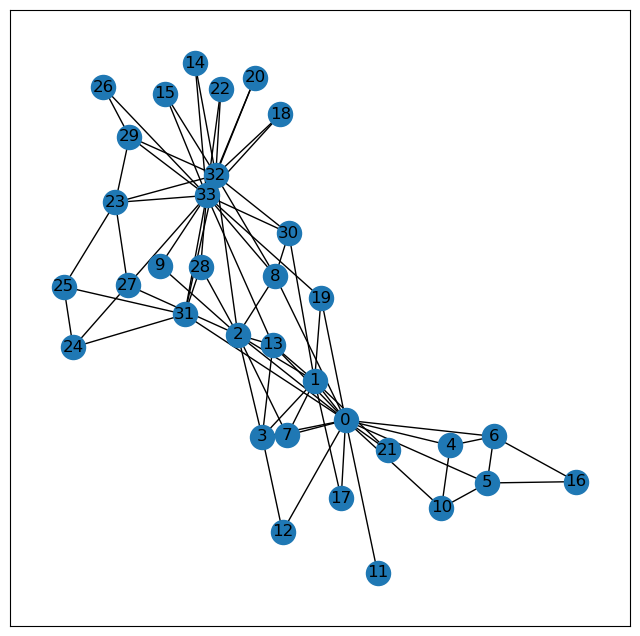

In [42]:
graph_zkc = to_networkx(dataset[0], to_undirected=True)
plt.figure(figsize=(8,8))
nx.draw_networkx(graph_zkc)
plt.show()

In [27]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
    
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []
# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass
    h, z = model(dataset.x, dataset.edge_index)
    # Calculate loss function
    loss = criterion(z, dataset.y)
    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), dataset.y)
    # Compute gradients
    loss.backward()
    # Tune parameters
    optimizer.step()
    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.41 | Acc: 35.29%
Epoch  10 | Loss: 1.20 | Acc: 35.29%
Epoch  20 | Loss: 0.92 | Acc: 73.53%
Epoch  30 | Loss: 0.72 | Acc: 73.53%
Epoch  40 | Loss: 0.61 | Acc: 73.53%
Epoch  50 | Loss: 0.53 | Acc: 73.53%
Epoch  60 | Loss: 0.41 | Acc: 82.35%
Epoch  70 | Loss: 0.27 | Acc: 97.06%
Epoch  80 | Loss: 0.15 | Acc: 100.00%
Epoch  90 | Loss: 0.09 | Acc: 100.00%
Epoch 100 | Loss: 0.06 | Acc: 100.00%
Epoch 110 | Loss: 0.04 | Acc: 100.00%
Epoch 120 | Loss: 0.03 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.02 | Acc: 100.00%
Epoch 150 | Loss: 0.01 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


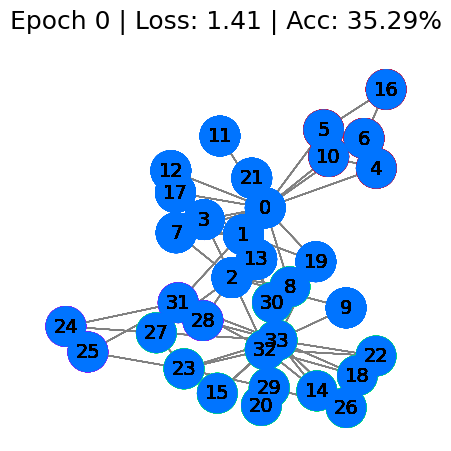

In [37]:
plt.rcParams["animation.bitrate"] = 3000
def animate(i):
    G = to_networkx(dataset[0], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)
    

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, 
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

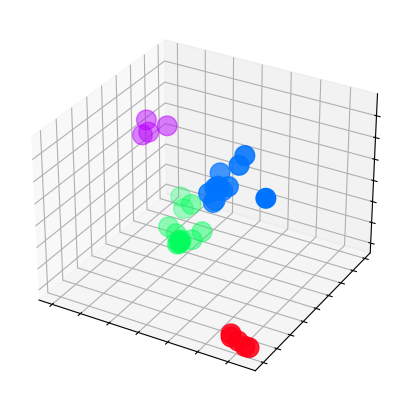

In [40]:
embed = h.detach().cpu().numpy()
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=dataset.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

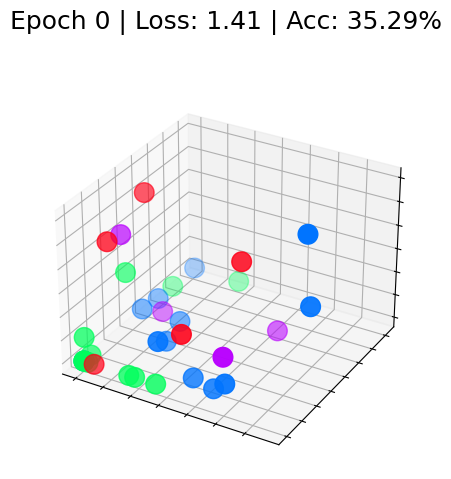

In [41]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=dataset.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
anim = animation.FuncAnimation(fig, animate, 
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)